In [6]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from numpy import clip
from torch.autograd import Variable
import torch
from torch import Tensor
from torch.optim import SGD, Adam
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact
from torch.nn.functional import softplus
w = widgets.IntText()
%matplotlib inline
%run utils.py
%load_ext Cython
from numpy.random import permutation
M, N = 20, 70

# file to run model on
filename = 'data/split/JC_week1_hour4_40x140.csv'

def log_sum_exp(value):
    m = torch.max(value)
    sum_exp = torch.sum(torch.exp(value - m))
    return m + torch.log(sum_exp)

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [7]:
%%cython 
import numpy as np
cimport numpy as np

cdef int M = 20
cdef int N = 70
DTYPE = int
ctypedef np.int_t DTYPE_t


def random_path(int sx, int sy, int tx, int ty, int L):
    """sample L random paths from sx, sy to tx, ty"""
    cdef int hor_dir, ver_dir, X, Y, XY
    
    hor_dir = (tx - sx) > 0
    ver_dir = (ty - sy) > 0
    
    cdef np.ndarray[DTYPE_t, ndim=3] paths = np.zeros([M, N, L], dtype=DTYPE)
    paths[sx,sy,:] = 1
    
    X = abs(tx - sx) 
    Y = abs(ty - sy) 
    XY = X + Y
    
    cdef np.ndarray[DTYPE_t, ndim=1] path = np.zeros(X+Y, dtype=DTYPE)
    path[:X] = 1
    
    cdef int l, i, x, y

    for l in range(L):
        x, y = sx, sy
        np.random.shuffle(path)
        for i in range(XY):
            if path[i]:
                x += 2 * hor_dir - 1
            else:
                y += 2 * ver_dir - 1
            paths[x,y,l] = 1
    return paths

In [8]:
L = 50
s2 = 10 ** 2 # sigma2 = (10 s) ** 2

In [55]:
Losses = []
for hour in [0,4,8,10,12,18,20]:
    filename = 'data/split_test/JC_week1_hour{}_test_40x140.csv'.format(hour)
    weight = softplus(Variable(Tensor(
        np.load('results/weights_week1hour{}_1.npy'.format(hour)))))
    df = pd.read_csv(filename)
    losses = []
    with tqdm(total=len(df)) as pbar:
        for _, duration, sx, sy, tx, ty in df.itertuples():
            pbar.update(1)
            paths = random_path(int(sx), int(sy), 
                                int(tx), int(ty), L)
            pred = (weight.unsqueeze(-1) * Variable(Tensor(paths.astype(float)))).sum() / L
            loss = duration - pred.data[0]
            losses.append(loss)
        Losses.append(np.array(losses)/60)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [9]:
filename = 'data/split_test/JC_week1_hour8_test_40x140.csv'
weight = softplus(Variable(Tensor(
    np.load('results/weights_week1hour8_4.npy'))))
df = pd.read_csv(filename)
df[['sx', 'sy','tx','ty']] = df[['sx', 'sy','tx','ty']] // 2
losses = []
with tqdm(total=len(df)) as pbar:
    for _, duration, sx, sy, tx, ty in df.itertuples():
        pbar.update(1)
        paths = random_path(int(sx), int(sy), 
                            int(tx), int(ty), L)
        pred = (weight.unsqueeze(-1) * Variable(Tensor(paths.astype(float)))).sum() / L
        loss = duration - pred.data[0]
        losses.append(loss)
    # Losses.append(np.array(losses)/60)

A Jupyter Widget

<Container object of 199 artists>

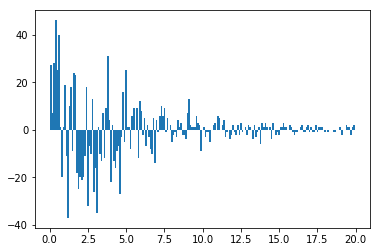

In [34]:
bins = np.arange(0,20,0.1)
x, _ = np.histogram(((pd.Series(losses))/60).abs(), bins)
y, _ = np.histogram(((pd.Series(losses)
                      - pd.Series(losses).mean())/60).abs(),
                   bins)
plt.bar(bins[1:], x-y, 0.1)

# np.histogram
# ((pd.Series(losses))/60).abs().hist(alpha=0.5,bins=)
# ((pd.Series(losses) - pd.Series(losses).mean())/60).abs().hist(alpha=0.5,bins=np.arange(0,20,0.1))


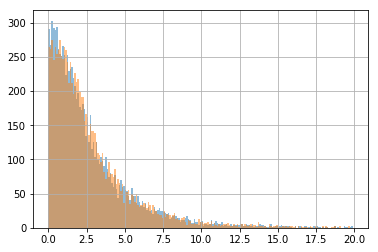

In [36]:
# np.histogram
((pd.Series(losses))/60).abs().hist(alpha=0.5,bins=bins)
((pd.Series(losses) - pd.Series(losses).mean())/60).abs().hist(alpha=0.5,bins=np.arange(0,20,0.1))


In [43]:
np.array(losses).mean()/60

0.80079481220987891

In [1]:
from pickle import dump, load

In [ ]:
dump(Losses, open('results/losses_JC_model.pickle','wb'))

In [2]:
Losses = load(open('results/losses_JC_model.pickle','rb'))

In [8]:
sds = []
for hour in ([0,4,8,10,12,18,20]):
    df = pd.read_csv('data/split_test/JC_week1_hour{}_test_40x140.csv'.format(hour))
    sds.append(df['duration'].std()/60)

In [16]:
preds = pd.DataFrame({
    'Std(duration)' : sds,
    'Mean(error)' : list(map(lambda x : x.mean(), Losses)),
    'Std(error)' : list(map(lambda x : x.std(), Losses)),
    'Mean(|error|)' : list(map(lambda x : np.abs(x).mean(), Losses)),
    'Std(|error|)' : list(map(lambda x : np.abs(x).std(), Losses)),
    'Median(|error|)' : list(map(lambda x : np.percentile(np.abs(x),50), Losses)),
    '99pctl(|error|)' : list(map(lambda x : np.percentile(np.abs(x),99), Losses))
}, index=[0,4,8,10,12,18,20])

In [18]:
preds['Imputed R^2'] = 1 - (preds['Std(error)'] / preds['Std(duration)']) ** 2

In [26]:
preds = preds[['Std(duration)', 'Mean(error)', 'Std(error)', 'Mean(|error|)', 'Std(|error|)', 'Median(|error|)', '99pctl(|error|)', 'Imputed R^2']]

In [28]:
preds.index.name = 'Hour of day'

In [38]:
print(preds.transpose().to_latex(float_format='%.2f'))

\begin{tabular}{lrrrrrrr}
\toprule
Hour of day &    0  &    4  &    8  &    10 &    12 &    18 &    20 \\
\midrule
Std(duration)   &  5.23 &  5.00 &  6.22 &  6.07 &  6.34 &  5.73 &  4.92 \\
Mean(error)     &  0.86 &  0.68 &  0.83 &  0.82 &  1.01 &  0.86 &  0.85 \\
Std(error)      &  3.85 &  3.53 &  4.34 &  4.43 &  4.79 &  3.86 &  3.43 \\
Mean(|error|)   &  2.27 &  2.12 &  2.87 &  2.96 &  2.90 &  2.62 &  2.30 \\
Std(|error|)    &  3.23 &  2.91 &  3.35 &  3.39 &  3.95 &  2.96 &  2.69 \\
Median(|error|) &  1.47 &  1.32 &  1.94 &  1.96 &  1.87 &  1.82 &  1.58 \\
99pctl(|error|) & 14.76 & 14.94 & 15.06 & 14.67 & 16.35 & 13.37 & 12.39 \\
Imputed R\textasciicircum2     &  0.46 &  0.50 &  0.51 &  0.47 &  0.43 &  0.55 &  0.51 \\
\bottomrule
\end{tabular}



In [2]:
loss = np.load('results/losses_week1hour8_1.npy')

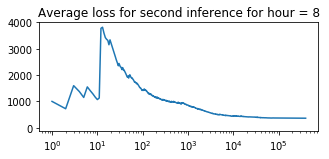

In [23]:
plt.figure(figsize=(5,2))
plt.plot(loss.cumsum()/np.arange(1,1+len(loss)))
plt.xscale('log')
plt.title('Average loss for second inference for hour = 8')
plt.savefig('figs/error_8h.png', dpi=1000)

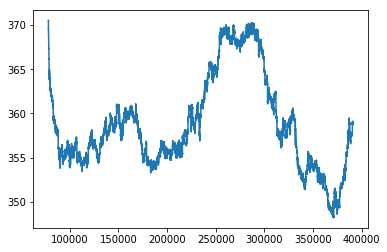

In [13]:
plt.plot(pd.Series(loss).rolling(window=390810//5).mean())